In [118]:
# homework from: https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2023/04-evaluation/homework.md

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt


%matplotlib inline

In [119]:
# Use only these columns, as per homework 
columns=["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type", "Vehicle Style", "highway MPG", "city mpg", "MSRP"]
df = pd.read_csv('../03-classification/car-price_data.csv' , usecols=columns)

In [120]:
# Data preparation
# Select only the features from above and transform their names using the next line:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [121]:
#Rename MSRP variable to price.
df.rename(columns={"msrp": "price"}, inplace=True)
df.head()

mean=df.price.mean()
mean

df['above_average'] = np.where(df['price']>=mean,1,0)
df

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0
...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120,1
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670,1
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620,1
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920,1


In [122]:
# separate numerical and categorical columns
numerical=["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]
categorical=["make", "model", "transmission_type", "vehicle_style" ]
df[categorical].nunique()

make                  48
model                915
transmission_type      5
vehicle_style         16
dtype: int64

In [123]:
# find and fix null values
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
above_average         0
dtype: int64

In [124]:
#Fill in the missing values of the selected features with 0.
df['engine_hp'].fillna(0, inplace=True)
df.engine_cylinders.fillna(0, inplace=True)
df.isnull().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
price                0
above_average        0
dtype: int64

In [125]:
# Split data into training, validation and testing
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

Question 1: ROC AUC feature importance. Which numerical variable has the highest AUC?

In [126]:
# For each numerical variable, use it as score and compute AUC with the above_average variable, Use the training dataset for that.
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

     year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
 city_mpg, 0.673


Answer: The variable "engine_hp" has the highest AUC score

Question 2: Training the model. What's the AUC of this model on the validation dataset?

In [127]:
# Apply one-hot-encoding using DictVectorizer 

columns = categorical + numerical

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

# Now train the logistic regression with these parameters:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

round (roc_auc_score(y_val, y_pred), 4)


0.9796

In [128]:
Answer: 0.979

Question 3: Precision and Recall. At which threshold precision and recall curves intersect?

In [129]:
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01. For each threshold, compute precision and recall
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


#@ IMPLEMENTATION OF FUNCTION:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]



,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,330,10,1399
20,0.2,623,201,31,1528
30,0.3,607,138,47,1591
40,0.4,593,104,61,1625
50,0.5,570,69,84,1660
60,0.6,550,50,104,1679
70,0.7,509,26,145,1703
80,0.8,468,15,186,1714
90,0.9,377,3,277,1726


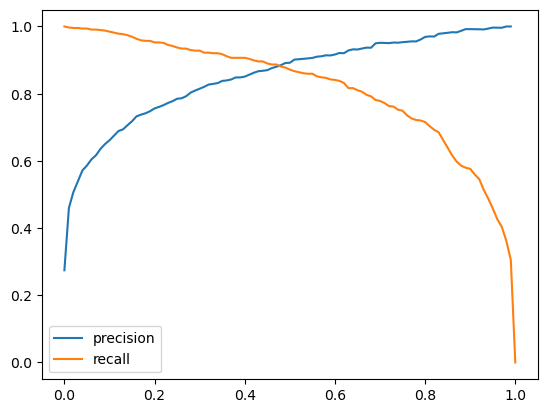

In [130]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

#Plot them
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

Answer Q3: They intersect at 0.48

Question 4: F1 score - A metric that combines Precision and Recall into one.

In [131]:
# To compute the F1 score:     F1 score = 2 * P * R / (P + R)

df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
df_scores['f1']

0      0.430688
1      0.629648
2      0.672173
3      0.699624
4      0.725851
         ...   
96     0.597430
97     0.574538
98     0.531987
99     0.468384
100         NaN
Name: f1, Length: 101, dtype: float64

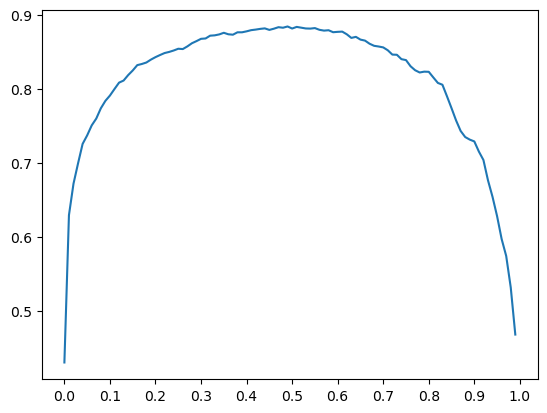

In [132]:
# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Answer - At which threshold F1 is maximal? At 0.52

Question 5: 5-Fold CV - How large is standard devidation of the scores across different folds?

In [133]:
# Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds
# Iterate over different folds of df_train_full
# Split the data into train and validation
# Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# Use AUC to evaluate the model on validation

def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [134]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.980 +- 0.004


Answer: 0.004 (closest option to 0.003)

Question 6: Hyperparemeter Tuning. use 5-Fold cross-validation to find the best parameter C. Which C leads to the best mean score?



In [139]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.002
C= 0.1, 0.971 +- 0.001
C=   1, 0.980 +- 0.004
C=  10, 0.981 +- 0.003


In [ ]:
Answer:  C=10 